# Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download utkarshps/skin-cancer-mnist10000-ham-augmented-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshps/skin-cancer-mnist10000-ham-augmented-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('skin-cancer-mnist10000-ham-augmented-dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()
print("Dataset Loaded")

Dataset Loaded


# Modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import matplotlib.image as mpimg

from scipy import stats
from sklearn.manifold import TSNE
from skimage import exposure
from skimage.filters import gaussian
from skimage.feature import canny
from skimage.restoration import denoise_bilateral
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers,models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from tensorflow.keras.applications import VGG16,DenseNet121,ResNet50V2
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import EfficientNetB4,EfficientNetB7,EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization, Input

import os
import math
import shutil
from pathlib import Path
from PIL import Image
import imutils
import cv2
import glob
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Initial Total

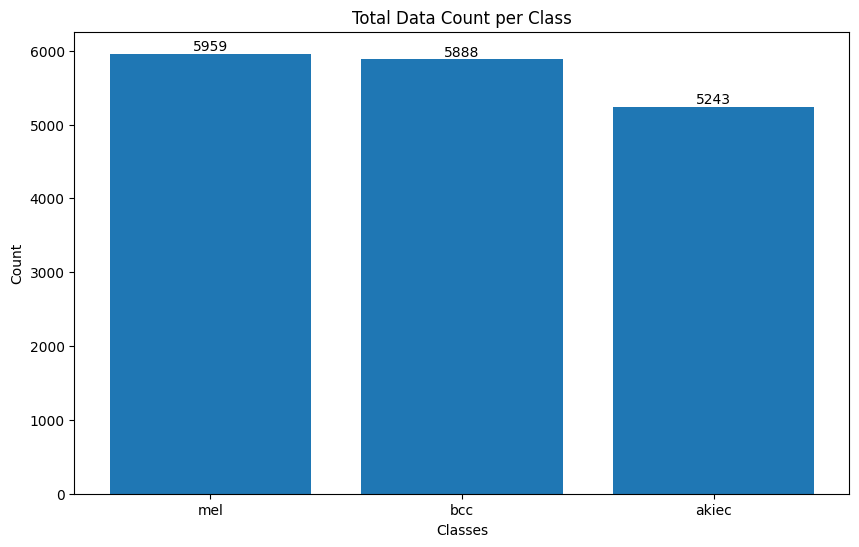

In [ ]:

import os
import matplotlib.pyplot as plt
import seaborn as sns

classes = ['mel', 'bcc', 'akiec']
base_dir = '/content/base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

class_counts = {}

for class_name in classes:
    train_path = os.path.join(train_dir, class_name)
    val_path = os.path.join(val_dir, class_name)

    train_count = len([name for name in os.listdir(train_path) if os.path.isfile(os.path.join(train_path, name))])
    val_count = len([name for name in os.listdir(val_path) if os.path.isfile(os.path.join(val_path, name))])

    total_count = train_count + val_count
    class_counts[class_name] = total_count

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.title('Total Data Count per Class')
plt.xlabel('Classes')
plt.ylabel('Count')

for bar, count in zip(bars, class_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.show()


# Undersampling Dataset

In [ ]:


import os
import shutil
import random


def undersample_dataset(source_dirs, target_dir, classes, sample_size):

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in classes:
        class_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_target_dir, exist_ok=True)

        class_images = []
        for source_dir in source_dirs:
            class_path = os.path.join(source_dir, class_name)
            if os.path.exists(class_path):
                class_images.extend([os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])

        sampled_images = random.sample(class_images, min(sample_size, len(class_images)))

        for image_path in sampled_images:
            try:
                shutil.copy(image_path, class_target_dir)
            except FileNotFoundError:
                print(f"Warning: Image file not found: {image_path}")


source_directories = [train_dir, val_dir]
target_directory = 'Dataset'
selected_classes = ['mel', 'bcc', 'akiec']
desired_sample_size = 5200  

undersample_dataset(source_directories, target_directory, selected_classes, desired_sample_size)

print(f"Undersampled dataset created at: {target_directory}")


Undersampled dataset created at: Dataset


In [ ]:
print(len(os.listdir('/content/Dataset/mel')))
print(len(os.listdir('/content/Dataset/bcc')))
print(len(os.listdir('/content/Dataset/akiec')))

5200
5200
5200


# Params

In [ ]:
image_h = 224
image_w = 224
BATCH = 32
EPOCH = 30
classes = 3
channels = 3
image_h,image_w

(224, 224)

In [ ]:
dataset_folder = '/content/Dataset'


labels = ['mel', 'bcc', 'akiec']

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(dataset_folder, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)
train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})


# 5200

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    # rotation_range=45,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True ,
    # brightness_range=[0.8, 1.2]  # Adjust brightness
    # fill_mode='nearest'
)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH,
    shuffle=False
)
# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)




Found 11271 validated image filenames belonging to 3 classes.
Found 2340 validated image filenames belonging to 3 classes.
Found 1989 validated image filenames belonging to 3 classes.


# 5000

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    # rotation_range=45,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True ,
    # brightness_range=[0.8, 1.2]  # Adjust brightness
    # fill_mode='nearest'
)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH,
    shuffle=False
)
# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    target_size=(image_h,image_w),
    batch_size=BATCH
)




Found 10837 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 1913 validated image filenames belonging to 3 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              restore_best_weights=True,
                              verbose=False)

def scheduler(epoch, lr):
    decay = -0.1
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * math.exp((epoch + 1) * decay))

lrscheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(
    "model_checkpoint.keras",
    monitor="val_loss",
    verbose=False,
    save_best_only=True,
    mode="auto",
)

callbacks = [checkpoint, lrscheduler, early_stopping]

# 5200 each class


# Custom CNN

In [ ]:
cnn_model = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(image_h, image_w, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    # Flatten
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # dropout

    # final dense
    layers.Dense(3, activation='softmax')
])




In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 53, 53, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      11,944,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,323,779 (47.01 MB)

 Trainable params: 12,322,371 (47.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 136s 321ms/step - accuracy: 0.5916 - loss: 1.1585 - val_accuracy: 0.3328 - val_loss: 2.3443 - learning_rate: 1.0000e-04
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.6895 - loss: 0.7906 - val_accuracy: 0.3741 - val_loss: 3.7184 - learning_rate: 1.0000e-04
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 100s 283ms/step - accuracy: 0.7216 - loss: 0.7121 - val_accuracy: 0.5013 - val_loss: 3.7292 - learning_rate: 1.0000e-04
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 100s 282ms/step - accuracy: 0.7511 - loss: 0.6436 - val_accuracy: 0.5721 - val_loss: 2.0935 - learning_rate: 1.0000e-04
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 98s 277ms/step - accuracy: 0.7704 - loss: 0.5960 - val_accuracy: 0.5063 - val_loss: 2.2621 - learning_rate: 1.0000e-04
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 99s 280ms/step - accuracy: 0.8068 - loss: 0.5226 - val_accuracy: 0.6561 - val_loss: 1.0539 - learning_rate: 5.4881e-05
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 98

Graphs 



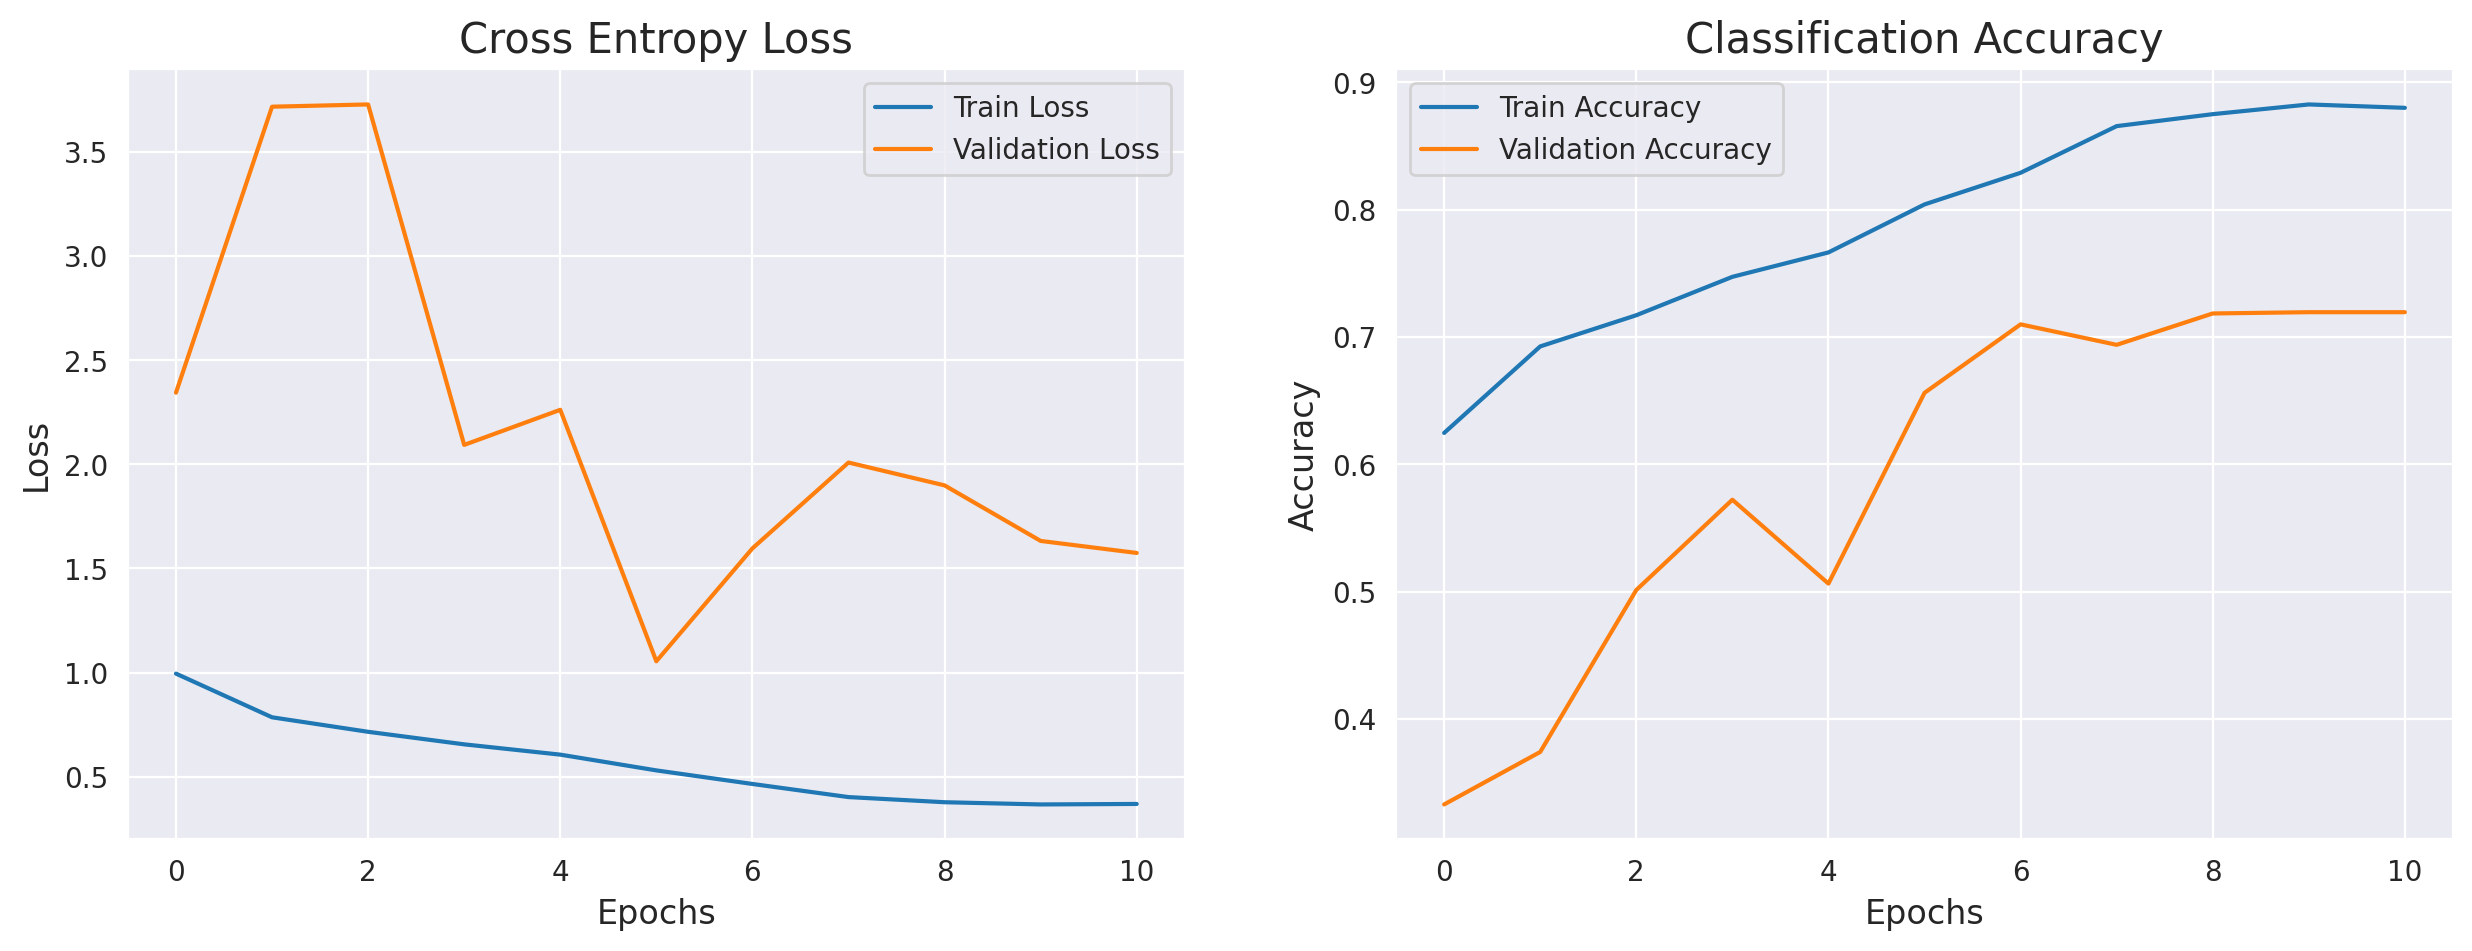


Model Testing 

The accuracy of the model for testing data is: 64.01709318161011
The Loss of the model for testing data is: 0.9948284029960632
Correct predicted classes: 1498
Incorrect predicted classes: 842

Classification Report 

              precision    recall  f1-score   support

       akiec       0.72      0.44      0.55       780
         bcc       0.52      0.92      0.66       780
         mel       0.92      0.56      0.70       780

    accuracy                           0.64      2340
   macro avg       0.72      0.64      0.64      2340
weighted avg       0.72      0.64      0.64      2340

Confusion Matrix 



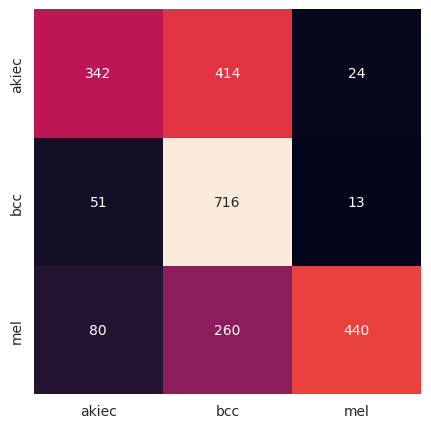

In [ ]:
all_evaluation(cnn_model)

# VGG 16

In [ ]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_h, image_w, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

display(vgg_model.summary())



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,824,451 (106.14 MB)

 Trainable params: 13,109,763 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

In [ ]:

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 108s 264ms/step - accuracy: 0.4655 - loss: 1.0714 - val_accuracy: 0.6616 - val_loss: 0.8114 - learning_rate: 1.0000e-04
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 110s 212ms/step - accuracy: 0.6325 - loss: 0.8189 - val_accuracy: 0.7139 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.6867 - loss: 0.7235 - val_accuracy: 0.7315 - val_loss: 0.6611 - learning_rate: 1.0000e-04
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.7087 - loss: 0.6868 - val_accuracy: 0.7476 - val_loss: 0.6221 - learning_rate: 1.0000e-04
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.7364 - loss: 0.6194 - val_accuracy: 0.7531 - val_loss: 0.5862 - learning_rate: 1.0000e-04
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 83s 234ms/step - accuracy: 0.7564 - loss: 0.5822 - val_accuracy: 0.7476 - val_loss: 0.5913 - learning_rate: 5.4881e-05
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 79s 

Graphs 



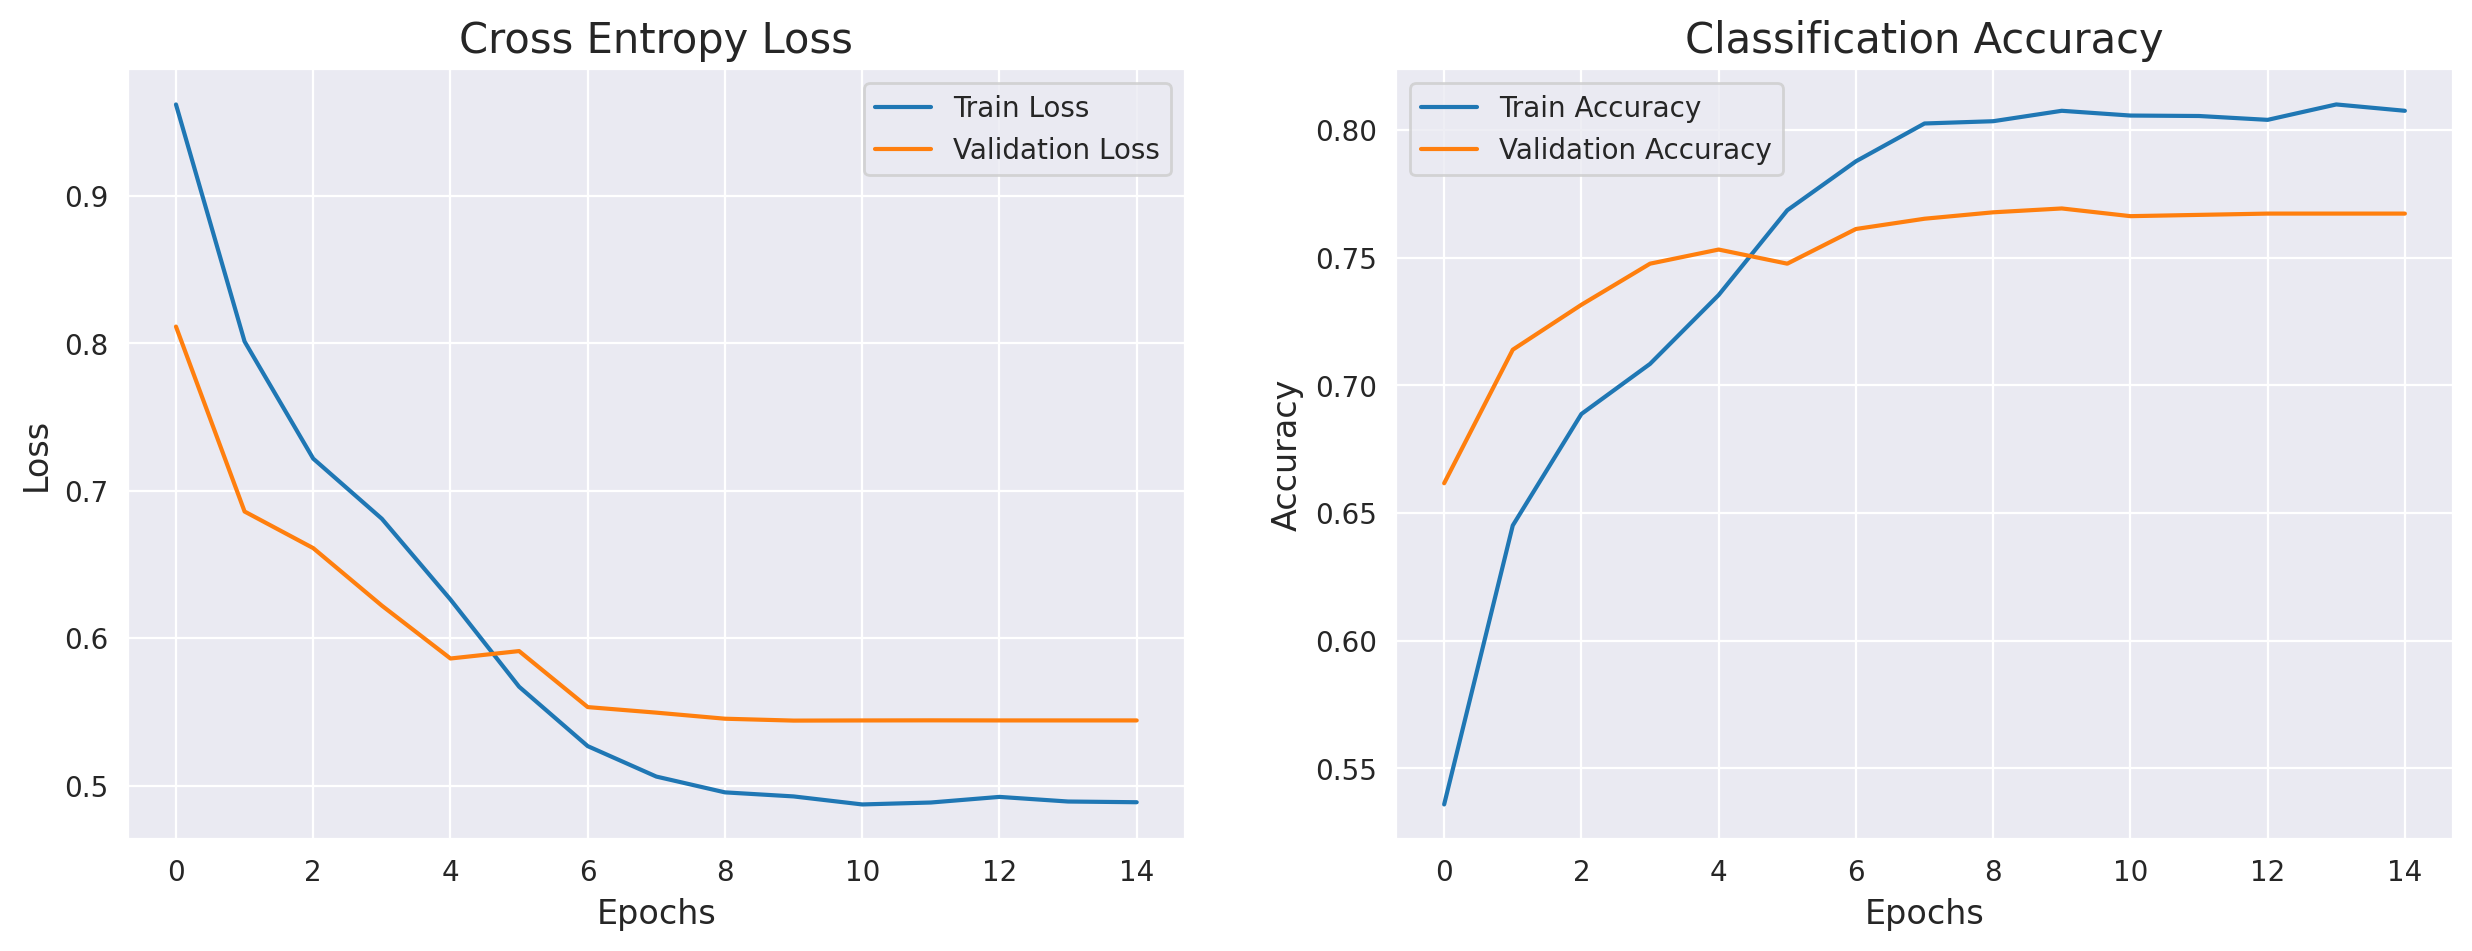


Model Testing 

The accuracy of the model for testing data is: 76.88034176826477
The Loss of the model for testing data is: 0.5653486251831055
Correct predicted classes: 1799
Incorrect predicted classes: 541

Classification Report 

              precision    recall  f1-score   support

       akiec       0.73      0.74      0.73       780
         bcc       0.77      0.78      0.77       780
         mel       0.81      0.79      0.80       780

    accuracy                           0.77      2340
   macro avg       0.77      0.77      0.77      2340
weighted avg       0.77      0.77      0.77      2340

Confusion Matrix 



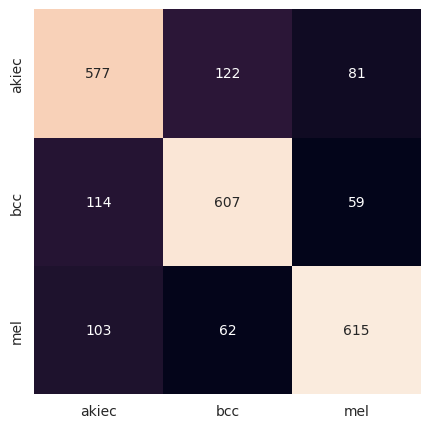

In [ ]:
all_evaluation(vgg_model)

# 5000 each class

 
# Custom CNN

In [ ]:
cnn_model2 = models.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(image_h, image_w, 3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),
    layers.Dropout(0.2),

    # Flatten
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # dropout

    # final dense
    layers.Dense(3, activation='softmax')
])




In [ ]:
cnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 53, 53, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 53, 53, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │      11,944,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,323,779 (47.01 MB)

 Trainable params: 12,322,371 (47.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
# Compile the model
cnn_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model2.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    epochs=EPOCH,
    callbacks=callbacks,
    verbose=True
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 111s 293ms/step - accuracy: 0.5895 - loss: 1.1501 - val_accuracy: 0.3333 - val_loss: 4.1259 - learning_rate: 1.0000e-04
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 132s 277ms/step - accuracy: 0.6861 - loss: 0.8065 - val_accuracy: 0.4816 - val_loss: 1.4912 - learning_rate: 1.0000e-04
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 141s 276ms/step - accuracy: 0.7225 - loss: 0.7140 - val_accuracy: 0.6908 - val_loss: 1.0501 - learning_rate: 1.0000e-04
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 97s 276ms/step - accuracy: 0.7502 - loss: 0.6379 - val_accuracy: 0.7250 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 97s 276ms/step - accuracy: 0.7801 - loss: 0.5917 - val_accuracy: 0.6551 - val_loss: 0.9336 - learning_rate: 1.0000e-04
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 98s 276ms/step - accuracy: 0.8129 - loss: 0.5190 - val_accuracy: 0.6747 - val_loss: 0.8952 - learning_rate: 5.4881e-05
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 97s

Graphs 



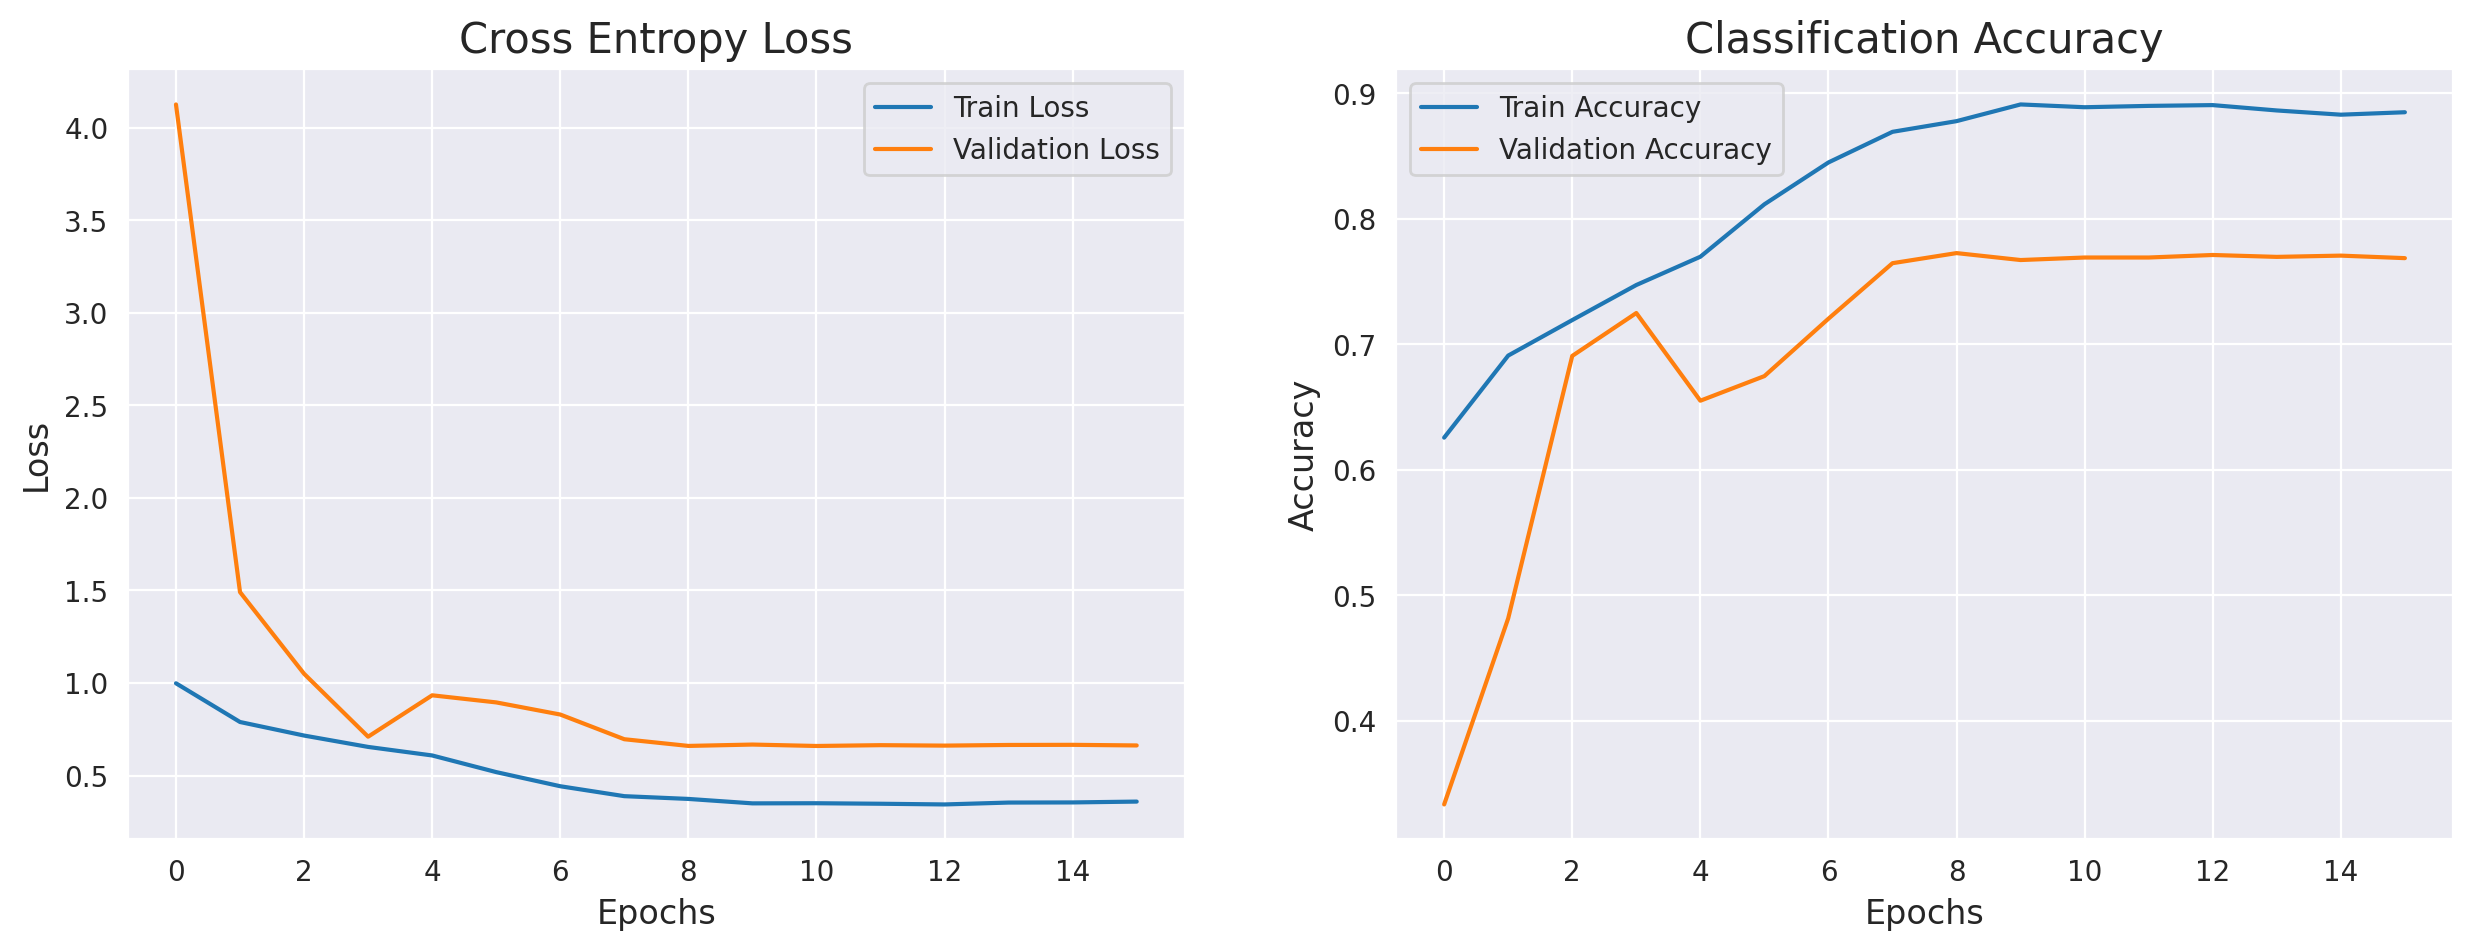


Model Testing 

The accuracy of the model for testing data is: 74.7863233089447
The Loss of the model for testing data is: 0.7102348208427429
Correct predicted classes: 1750
Incorrect predicted classes: 590

Classification Report 

              precision    recall  f1-score   support

       akiec       0.75      0.62      0.68       780
         bcc       0.66      0.86      0.75       780
         mel       0.88      0.76      0.82       780

    accuracy                           0.75      2340
   macro avg       0.76      0.75      0.75      2340
weighted avg       0.76      0.75      0.75      2340

Confusion Matrix 



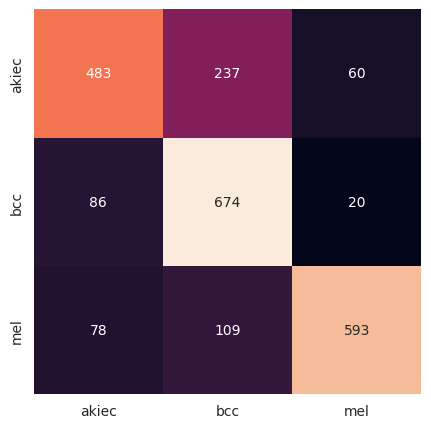

In [ ]:
all_evaluation(cnn_model2)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Class labels
class_labels = train_gen.class_indices
class_labels = {v: k for k, v in class_labels.items()}
print(class_labels)



def predict_image(model, img_path, target_size=(image_h, image_w)):


    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)  #

    return class_labels[predicted_class], confidence


{0: 'akiec', 1: 'bcc', 2: 'mel'}


In [ ]:
img_path = "/content/44b5954d-d62e-4d72-af9b-0dbee736c8d2.jpg"
predicted_class, confidence = predict_image(model, img_path)
print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Class: mel, Confidence: 0.988


# vgg 16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_h, image_w, channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax',kernel_regularizer=l2(0.0001))(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

display(vgg_model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,824,451 (106.14 MB)

 Trainable params: 13,109,763 (50.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

In [ ]:
vgg_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.fit(
    train_gen,
    # steps_per_epoch=train_gen.samples // BATCH,
    epochs=EPOCH,
    validation_data=val_gen,
    # validation_steps=val_gen.samples // BATCH,
    callbacks= callbacks,
    verbose=True
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 98s 235ms/step - accuracy: 0.5125 - loss: 0.9841 - val_accuracy: 0.6450 - val_loss: 0.7606 - learning_rate: 1.0000e-04
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.6725 - loss: 0.7606 - val_accuracy: 0.7205 - val_loss: 0.6646 - learning_rate: 1.0000e-04
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 205ms/step - accuracy: 0.7127 - loss: 0.6875 - val_accuracy: 0.7310 - val_loss: 0.6257 - learning_rate: 1.0000e-04
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.7380 - loss: 0.6345 - val_accuracy: 0.7250 - val_loss: 0.6604 - learning_rate: 1.0000e-04
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.7607 - loss: 0.5903 - val_accuracy: 0.7481 - val_loss: 0.5852 - learning_rate: 1.0000e-04
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 206ms/step - accuracy: 0.7860 - loss: 0.5329 - val_accuracy: 0.7622 - val_loss: 0.5727 - learning_rate: 5.4881e-05
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 73s 20

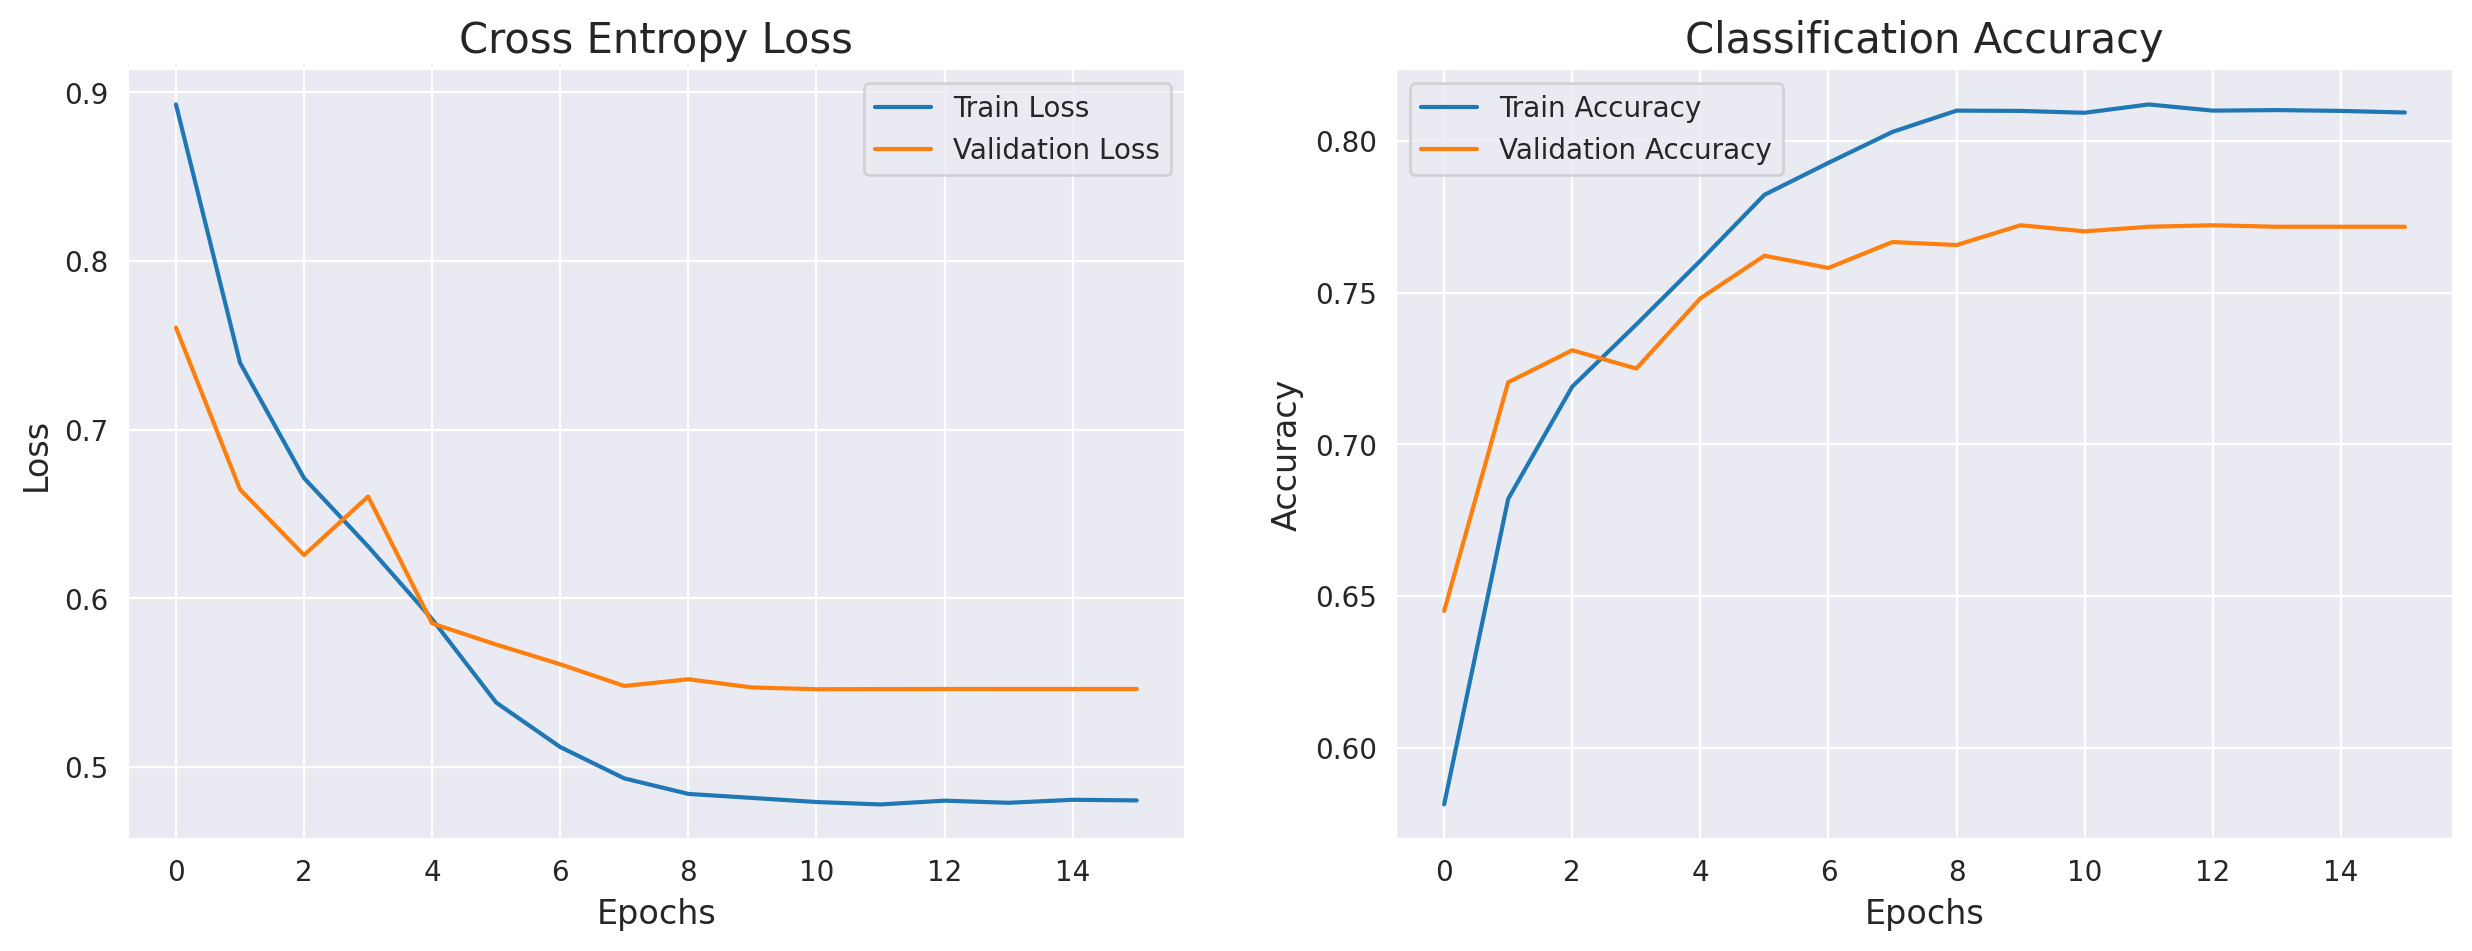

In [ ]:
# graphs
metrics = pd.DataFrame(vgg_model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

  # Loss and Val_loss
plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

  # Accuracy and Val_accuracy
plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()


Model Testing 

The accuracy of the model for testing data is: 77.13675498962402
The Loss of the model for testing data is: 0.5531635284423828
Correct predicted classes: 1805
Incorrect predicted classes: 535

Classification Report 

              precision    recall  f1-score   support

       akiec       0.73      0.75      0.74       780
         bcc       0.76      0.77      0.77       780
         mel       0.83      0.79      0.81       780

    accuracy                           0.77      2340
   macro avg       0.77      0.77      0.77      2340
weighted avg       0.77      0.77      0.77      2340

Confusion Matrix 



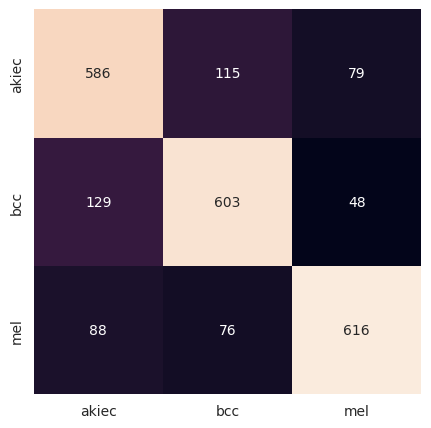

In [ ]:
all_evaluation(vgg_model)